<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Generalized Random Forest Module: Use Cases and Examples

Causal Forests and [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf) are a flexible method for estimating treatment effect heterogeneity with Random Forests. The `econml.grf` module implements a high-performance Cython version of the [`grf`](https://github.com/grf-labs/grf) R-package, with support for CausalForests, IVForests and RegressionForests. The module provides estimators that adhere to the scikit-learn fit and predict API, as well as providing methods for uncertainty quantification and confidence intervals.

Within the EconML SDK we use these estimators as final models for CATE estimation, such as in the case of `econml.dml.CausalForestDML`, where we combine a Causal Forest with Double Machine Learning, to residualize the treatment and outcome and call the `econml.grf.CausalForest` on the residuals. Similarly, the `econml.drlearner.ForestDRLearner` uses an `econml.grf.RegressionForest` as a final stage estimator on the doubly robust targets estimated by the first stage. The estimators here should primarily be used in conjunction with CateEstimators and not as standalone, but we provide here examples of their direct usage functionality.

The EconML SDK implements the following Generalized Random Forest variants:

* `CausalForest`: suitable for many continuous or discrete treatments, when there is no unobserved confounding

* `CausalIVForest`: suitable for many continuous or discrete treatments, when there is unobserved confounding and access to an instrument

* `RegressionForest`: an analogue of `sklearn.ensemble.RandomForestRegressor`, but with support for confidence intervals.

If you also have multiple outcomes, then the class `econml.grf.MultiOutputGRF`, is a wrapper class that wraps any generalized random forest and enables support for multiple outcomes by fitting a separate forest for each target outcome.

Our estimators provide support for the heterogeneity criterion as outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf), using `criterion='het'`, as well as a mean squared error criterion that penalizes high-variance splits, using `criterion='mse'`.[Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

Uncertainty quantification and confidence intervals is computed via the Bootstrap-of-Little-Bags approach outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

The tree data structure that is used to store each tree is compatible with `sklearn.tree._tree.Tree` and so scikit-learn functionalities on trees can be applied to our trained trees (e.g. tree plotting).


## Notebook Contents

1. [Causal Forest: Heterogeneous causal effects with no unobserved confounders](#1.-Causal-Forest:-Heterogeneous-causal-effects-with-no-unobserved-confounders)
2. [Causal IV Forest: Heterogeneous causal effects with unobserved confounders](#2.-Causal-IV-Forest:-Heterogeneous-causal-effects-with-unobserved-confounders)
3. [Regression Forest: Random Forest Regressor with confidence intervals](#3.-Regression-Forest:-Random-Forest-Regressor-with-confidence-intervals)
4. [Combining with Double Machine Learning](#4.-Combining-with-Double-Machine-Learning)

In [1]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

## 1. Causal Forest: Heterogeneous causal effects with no unobserved confounders

In [2]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_treatments = 1
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + np.random.normal(0, .5, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [3]:
est = CausalForest(criterion='het', n_estimators=4000, min_samples_leaf=5, max_depth=None,
                   min_var_fraction_leaf=None, min_var_leaf_on_val=True,
                   min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                   warm_start=False, inference=True, fit_intercept=True, subforest_size=4,
                   honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [4]:
est.fit(X, T, y)

CausalForest(criterion='het', min_var_leaf_on_val=True, n_estimators=4000,
             random_state=1235)

In [5]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

In [6]:
point = est.predict(X_test)

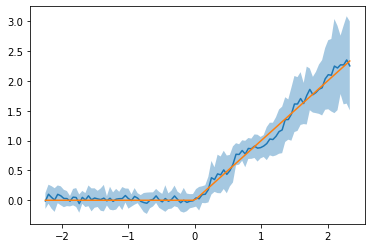

In [7]:
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

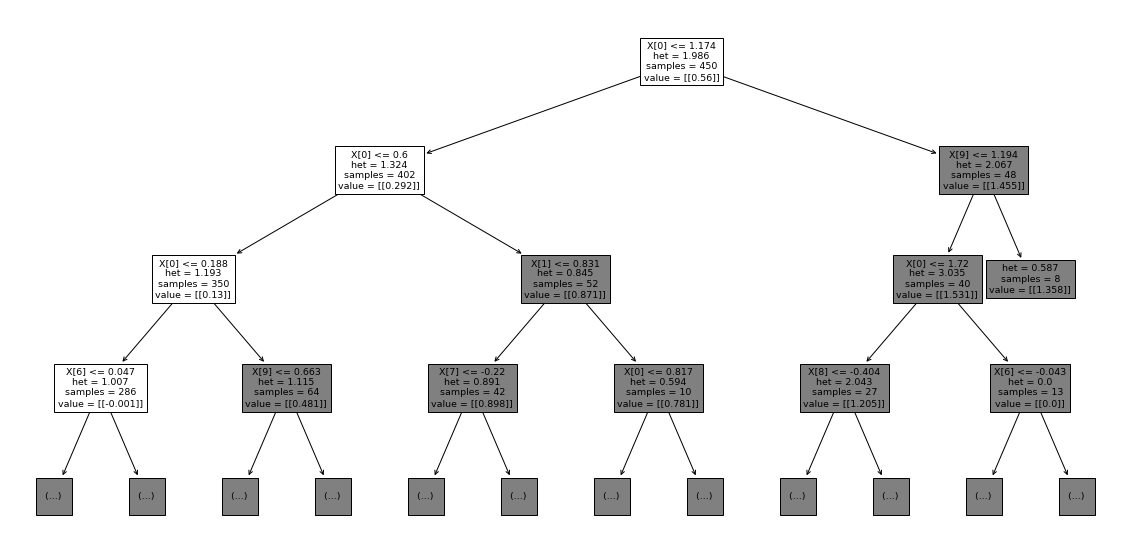

In [8]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=3)
plt.show()

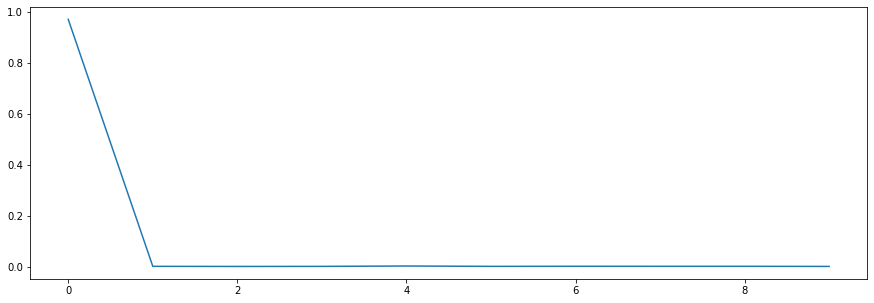

In [9]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [10]:
est.decision_path(X_test[:1])

(<1x476114 sparse matrix of type '<class 'numpy.int64'>'
 	with 38428 stored elements in Compressed Sparse Row format>,
 array([     0,    119,    234, ..., 475878, 475997, 476114], dtype=int32))

In [11]:
est.apply(X_test[:1])

array([[31, 24, 47, ..., 10, 11, 70]], dtype=int64)

## 2. Causal IV Forest: Heterogeneous causal effects with unobserved confounders

In [12]:
np.random.seed(1227)
n_samples = 2000
n_features = 10
n_treatments = 2
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10 * U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [13]:
from econml.grf import CausalIVForest
est = CausalIVForest(criterion='mse', n_estimators=4000, min_samples_leaf=40,
                     min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
                     min_impurity_decrease = 0.001, max_samples=.45, max_depth=None,
                     warm_start=False, inference=True, subforest_size=4,
                     honest=True, verbose=0, n_jobs=-1, random_state=123)

In [14]:
est.fit(X, T, y, Z=Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=4000, random_state=123)

In [15]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

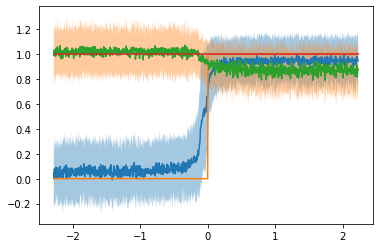

In [16]:
for t in range(n_treatments):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

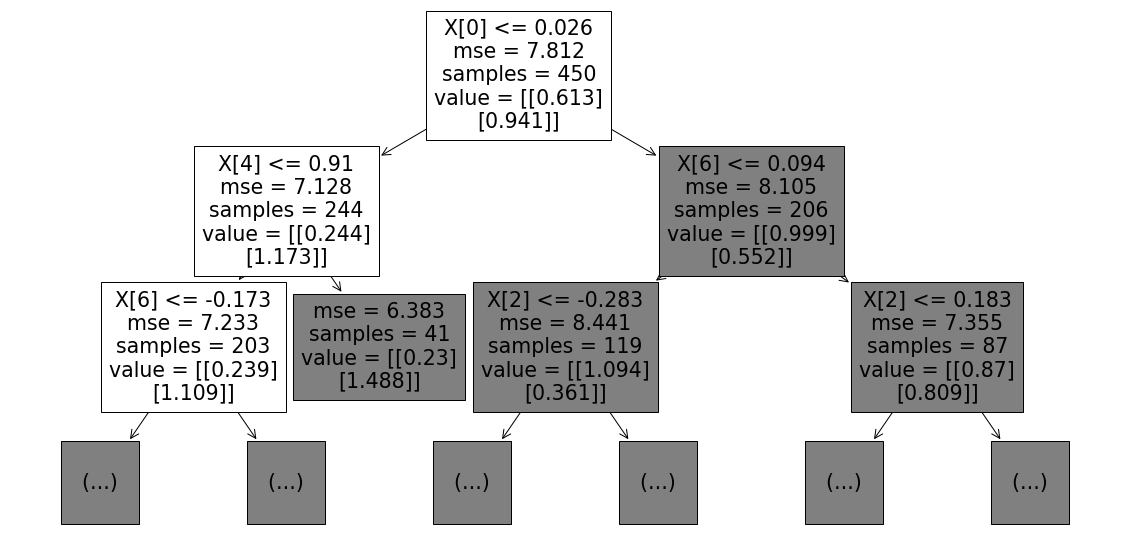

In [17]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

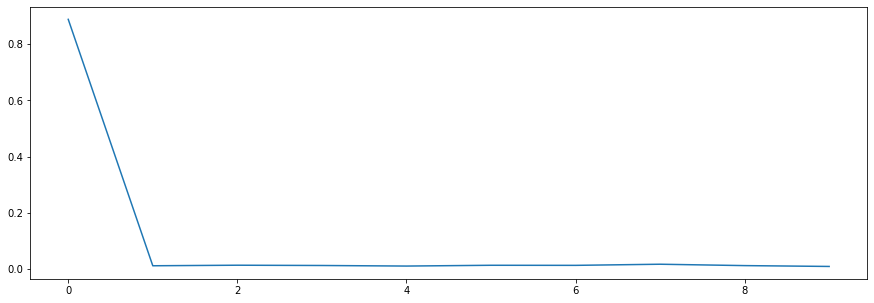

In [18]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

In [19]:
est[0].decision_path(X_test[:1])

<1x15 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [20]:
est[0].apply(X_test[:1])

array([3], dtype=int64)

## 3. Regression Forest: Random Forest Regressor with confidence intervals

In [21]:
np.random.seed(123)
n_samples = 2000
n_features = 10
n_outputs = 2
true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_outputs - 1))])
# true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
#                                np.ones((X.shape[0], n_outputs - 1))*np.arange(1, n_outputs).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [22]:
est = RegressionForest(n_estimators=4000, min_samples_leaf=5, max_depth=None,
                       min_impurity_decrease = 0.0, max_samples=0.45, min_balancedness_tol=.45,
                       warm_start=False, inference=True, subforest_size=4,
                       honest=True, verbose=0, n_jobs=-1, random_state=1235)

In [23]:
est.fit(X, y)

RegressionForest(n_estimators=4000, random_state=1235)

In [24]:
point, lb, ub = est.predict(X_test, interval=True, alpha=0.01)

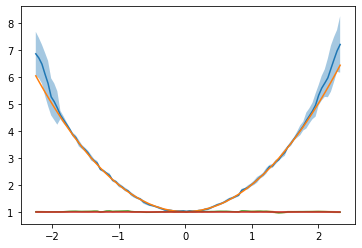

In [25]:
for t in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, t])
    if est.inference:
        plt.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha=.4)
    plt.plot(X_test[:, 0], true_te(X_test)[:, t])
plt.show()

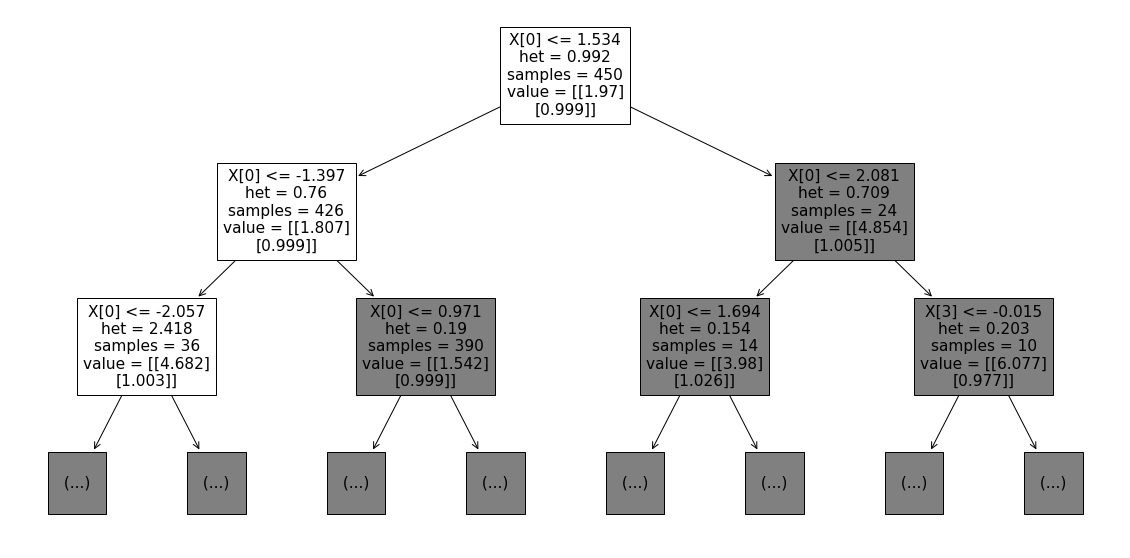

In [26]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=2)
plt.show()

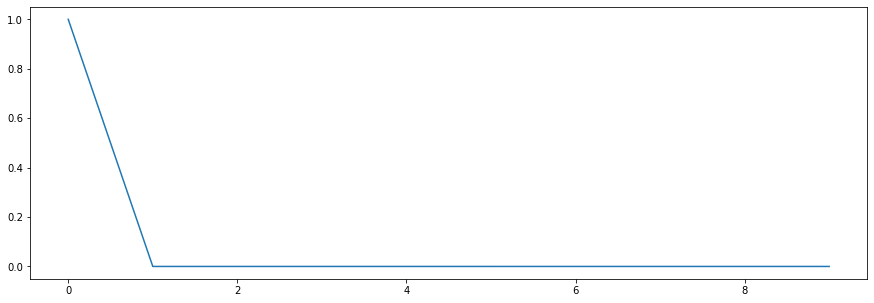

In [27]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

## 4. Combining with Double Machine Learning

In [28]:
np.random.seed(123)
n_samples = 5000
n_features = 10
n_treatments = 3
n_outputs = 2
# true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_treatments - 1))])
# true_te = lambda X: np.hstack([X[:, [0]]>0, np.ones((X.shape[0], n_treatments - 1))])
true_te = lambda X: np.hstack([(X[:, [0]]>0) * X[:, [0]],
                               np.ones((X.shape[0], n_treatments - 1))*np.arange(1, n_treatments).reshape(1, -1)])
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [29]:
est = CausalForestDML(n_crossfit_splits=2,
                      criterion='mse', n_estimators=4000,
                      min_var_fraction_leaf=0.1,
                      min_var_leaf_on_val=True,
                      verbose=0, discrete_treatment=False,
                      n_jobs=-1, random_state=123).fit(y, T, X=X, W=W)

In [30]:
res = est.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

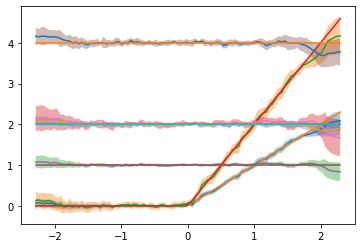

In [31]:
for t in range(n_treatments):
    for j in range(n_outputs):
        plt.plot(X_test[:, 0], point[:, j, t])
        plt.fill_between(X_test[:,0], lb[:, j, t], ub[:, j, t], alpha=.4)
        plt.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
plt.show()

In [32]:
res.summary_frame()

point_estimate               stderr                 zstat          \
                  T0     T1     T2     T0     T1     T2      T0      T1   
0  Y0          0.064  1.072  2.080  0.045  0.061  0.043   1.442  17.614   
   Y1          0.128  2.143  4.159  0.089  0.122  0.085   1.442  17.614   
1  Y0          0.073  1.076  2.075  0.030  0.058  0.035   2.431  18.667   
   Y1          0.146  2.152  4.150  0.060  0.115  0.071   2.431  18.667   
2  Y0          0.058  1.075  2.081  0.041  0.062  0.045   1.437  17.212   
...              ...    ...    ...    ...    ...    ...     ...     ...   
97 Y1          4.127  1.702  3.747  0.171  0.169  0.125  24.135  10.053   
98 Y0          2.080  0.840  1.889  0.086  0.087  0.060  24.217   9.615   
   Y1          4.160  1.680  3.777  0.172  0.175  0.120  24.217   9.615   
99 Y0          2.085  0.834  1.885  0.093  0.087  0.066  22.297   9.576   
   Y1          4.170  1.668  3.771  0.187  0.174  0.132  22.297   9.576   

              pvalue           ci_lower               ci_upper                
           T2     T0   T1   T2       T0     T1     T2       T0     T1     T2  
0  Y0  48.846  0.149  0.0  0.0   -0.009  0.971  2.009    0.137  1.172  2.150  
   Y1  48.846  0.149  0.0  0.0   -0.018  1.943  4.019    0.275  2.343  4.299  
1  Y0  58.496  0.015  0.0  0.0    0.024  0.981  2.016    0.122  1.171  2.133  
   Y1  58.496  0.015  0.0  0.0    0.047  1.963  4.033    0.244  2.342  4.266  
2  Y0  46.239  0.151  0.0  0.0   -0.008  0.973  2.007    0.125  1.178  2.155  
...       ...    ...  ...  ...      ...    ...    ...      ...    ...    ...  
97 Y1  29.987  0.000  0.0  0.0    3.846  1.423  3.541    4.408  1.980  3.953  
98 Y0  31.506  0.000  0.0  0.0    1.939  0.696  1.790    2.221  0.983  1.987  
   Y1  31.506  0.000  0.0  0.0    3.877  1.392  3.580    4.443  1.967  3.974  
99 Y0  28.512  0.000  0.0  0.0    1.931  0.691  1.777    2.239  0.977  1.994  
   Y1  28.512  0.000  0.0  0.0    3.862  1.381  3.553    4.477  1.954  3.988  

[200 rows x 18 columns]

In [33]:
res = est.effect_inference(X_test,
                           T0=np.zeros((X_test.shape[0], n_treatments)),
                           T1=np.ones((X_test.shape[0], n_treatments)))
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

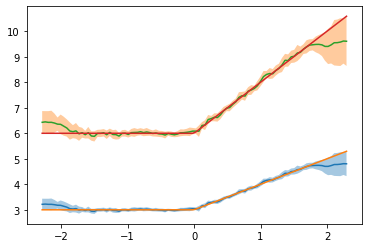

In [34]:
for j in range(n_outputs):
    plt.plot(X_test[:, 0], point[:, j])
    plt.fill_between(X_test[:,0], lb[:, j], ub[:, j], alpha=.4)
    plt.plot(X_test[:, 0], (j + 1) * np.sum(true_te(X_test), axis=1))
plt.show()

In [35]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
0  Y0           3.215   0.085  37.613     0.0     3.075     3.356
   Y1           6.431   0.171  37.613     0.0     6.149     6.712
1  Y0           3.224   0.082  39.486     0.0     3.089     3.358
   Y1           6.448   0.163  39.486     0.0     6.179     6.716
2  Y0           3.214   0.085  37.639     0.0     3.074     3.355
...               ...     ...     ...     ...       ...       ...
97 Y1           9.576   0.364  26.316     0.0     8.977    10.174
98 Y0           4.808   0.172  27.969     0.0     4.526     5.091
   Y1           9.617   0.344  27.969     0.0     9.051    10.182
99 Y0           4.804   0.188  25.559     0.0     4.495     5.113
   Y1           9.608   0.376  25.559     0.0     8.990    10.227

[200 rows x 6 columns]

In [36]:
est.feature_importances_

array([[0.98358816, 0.00210355, 0.00178466, 0.00230686, 0.00133594,
        0.00147465, 0.00175637, 0.00172072, 0.00241021, 0.00151888],
       [0.98358816, 0.00210355, 0.00178466, 0.00230686, 0.00133594,
        0.00147465, 0.00175637, 0.00172072, 0.00241021, 0.00151888]])